# 1. Imports & Config

In [31]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from numpy import ndarray
from matplotlib.pyplot import subplots, show
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, top_k_accuracy_score

# bias
from collections import Counter


# model building imports
import keras
from keras import Model, Sequential, Input
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.layers import LeakyReLU
from keras.ops import add
from keras.utils import to_categorical
from keras.optimizers import SGD
from keras.optimizers import Adam
from keras.losses import CategoricalCrossentropy
from keras.metrics import CategoricalAccuracy, AUC, F1Score, TopKCategoricalAccuracy
from keras.callbacks import ModelCheckpoint, CSVLogger, LearningRateScheduler ,ReduceLROnPlateau, EarlyStopping
from keras.utils import Sequence, load_img, img_to_array


# image filtering 
from tensorflow.keras.applications import ResNet50, EfficientNetB6
from tensorflow.keras.applications.efficientnet import preprocess_input, decode_predictions
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.utils import load_img, img_to_array
import numpy as np
from tqdm import tqdm

import keras_tuner
# augmentation operations
from keras.layers import RandomBrightness, RandomFlip, RandomRotation, RandomContrast
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Dense, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
from keras.layers import Pipeline
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.applications import ResNet50
from keras.applications import EfficientNetV2S
from keras.models import Model
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
from keras.initializers import Constant

In [32]:
import tensorflow as tf

# List all physical GPUs
gpus = tf.config.list_physical_devices('GPU')
print("Available GPUs:", gpus)


Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [33]:
print('num gpus:', len(tf.config.list_physical_devices('GPU')))

num gpus: 1


In [34]:
tf.config.run_functions_eagerly(True)

In [35]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Memory growth set")
    except RuntimeError as e:
        print(e)

Memory growth set


In [36]:
# importing the dataset
metadata = pd.read_csv('../rare_species 1/metadata.csv')
#metadata = pd.read_csv('../Data/rare_species/metadata.csv')
metadata.sample(5)

rare_species_id  eol_content_id  eol_page_id  \
3143  6e7c9903-9c37-435e-bd0e-a0f1d42631f7        12835841     46454284   
1875  8f293eeb-728b-43e5-b594-6b385ca2ee3c        29548215     47043290   
1173  9619275b-ed0d-4114-9ec3-93ff870c49d4        20244022     46560148   
4776  8c96c941-0ec1-485a-ba83-337a342889a2        21881723     46559800   
4399  abcf331e-7c76-42a0-8aac-bc7cc3604f4a        28508512       323914   

       kingdom    phylum          family  \
3143  animalia  mollusca         conidae   
1875  animalia  chordata    fringillidae   
1173  animalia  chordata     hexanchidae   
4776  animalia  chordata  carcharhinidae   
4399  animalia  chordata        atelidae   

                                              file_path  
3143  mollusca_conidae/12835841_46454284_eol-full-si...  
1875  chordata_fringillidae/29548215_47043290_eol-fu...  
1173  chordata_hexanchidae/20244022_46560148_eol-ful...  
4776  chordata_carcharhinidae/21881723_46559800_eol-...  
4399  chordata_atelidae/28508512_323914_eol-full-siz...

In [37]:
# applying the filepath
metadata['file_path'] = metadata['file_path'].apply(lambda x: os.path.join('../rare_species 1', x))

In [38]:
metadata.sample(5)

rare_species_id  eol_content_id  eol_page_id  \
8008   07ce200b-c168-4706-9328-5aa02eee1d73        22969028      1012078   
5882   40ea6cd4-4013-4f98-9407-4cfd60b32e7f        22292575     47048632   
10464  29443059-18ae-4f3d-9e0d-b5135f4ee933        29935041     46582216   
637    b3990453-1297-4517-b805-eeae8fe92489        28745800     46570656   
439    b8df5fbc-e866-4f06-94cf-a9255862262b        28219376     45276311   

        kingdom    phylum           family  \
8008   animalia  chordata  cyprinodontidae   
5882   animalia  chordata       vombatidae   
10464  animalia  chordata     latimeriidae   
637    animalia  chordata       balistidae   
439    animalia  cnidaria      acroporidae   

                                               file_path  
8008   ../rare_species 1/chordata_cyprinodontidae/229...  
5882   ../rare_species 1/chordata_vombatidae/22292575...  
10464  ../rare_species 1/chordata_latimeriidae/299350...  
637    ../rare_species 1/chordata_balistidae/28745800...  
439    ../rare_species 1/cnidaria_acroporidae/2821937...

# 2.  Preprocessing

In [39]:
metadata.phylum.unique()

array(['mollusca', 'chordata', 'arthropoda', 'echinodermata', 'cnidaria'],
      dtype=object)

In [40]:
print(metadata['family'].value_counts())

family
dactyloidae        300
cercopithecidae    300
formicidae         291
carcharhinidae     270
salamandridae      270
                  ... 
cyprinodontidae     30
alligatoridae       30
balaenidae          30
goodeidae           30
siluridae           29
Name: count, Length: 202, dtype: int64


In [41]:
num_classes = metadata['family'].nunique()
num_classes

202

our dataset is inbalaced and has a length of 202 classes

In [42]:
# Transforming our target and feature into a int
label_encoder = LabelEncoder()
metadata['target'] = label_encoder.fit_transform(metadata['family'])


In [43]:
metadata['target'].sample(10)

11137    148
124      130
10529     99
1728     104
6753       2
6859     100
2137      71
7578      16
6490      23
1856     119
Name: target, dtype: int64

## Cheking for misslabeled images/ images that are not supposed to be in our dataset

Even with False Positives the objective is to not discard more than 5% of our dataset

In [44]:
model = EfficientNetB6(weights="imagenet", include_top=True)

weird_samples = []

for _, row in tqdm(metadata.iterrows(), total=len(metadata)):
    path = row['file_path']
    true_label = row['family']

    try:
        img = load_img(path, target_size=(528, 528))
        x = img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)

        preds = model.predict(x, verbose=0)
        top_pred = decode_predictions(preds, top=1)[0][0]  # (id, label, prob)

        class_id = top_pred[0]  # e.g. 'n02124075'
        prob = top_pred[2]

        # ImageNet animals all fall into n02xxxxx
        if not class_id.startswith('n02') and prob > 0.85:
            print(f"Not animal (class_id={class_id}) → removed: labeled '{true_label}'")
            weird_samples.append((path, class_id, prob, true_label))

    except Exception as e:
        print(f"Error reading {path}: {e}")




  0%|          | 0/11983 [00:00<?, ?it/s]/home/ruben/anaconda3/envs/DeepLearn/lib/python3.12/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
  3%|▎         | 354/11983 [01:44<58:33,  3.31it/s]  

Not animal (class_id=n01855672) → removed: labeled 'anatidae'


  3%|▎         | 402/11983 [01:59<59:48,  3.23it/s]  

Not animal (class_id=n03530642) → removed: labeled 'merulinidae'


  4%|▍         | 471/11983 [02:20<57:57,  3.31it/s]  

Not animal (class_id=n06359193) → removed: labeled 'sphyrnidae'


  5%|▌         | 622/11983 [03:05<55:42,  3.40it/s]  

Not animal (class_id=n03794056) → removed: labeled 'cryptobranchidae'


  5%|▌         | 638/11983 [03:09<55:18,  3.42it/s]

Not animal (class_id=n01496331) → removed: labeled 'balistidae'


  7%|▋         | 884/11983 [04:23<55:36,  3.33it/s]  

Not animal (class_id=n01917289) → removed: labeled 'faviidae'


  8%|▊         | 931/11983 [04:36<54:19,  3.39it/s]

Not animal (class_id=n01855672) → removed: labeled 'anatidae'


 10%|▉         | 1161/11983 [05:46<54:49,  3.29it/s]  

Not animal (class_id=n01818515) → removed: labeled 'psittacidae'


 10%|█         | 1228/11983 [06:06<52:44,  3.40it/s]

Not animal (class_id=n01496331) → removed: labeled 'dasyatidae'


 11%|█         | 1292/11983 [06:26<53:13,  3.35it/s]  

Not animal (class_id=n03452741) → removed: labeled 'gavialidae'


 11%|█         | 1306/11983 [06:30<52:37,  3.38it/s]

Not animal (class_id=n01608432) → removed: labeled 'psittacidae'


 11%|█▏        | 1375/11983 [06:50<54:31,  3.24it/s]

Not animal (class_id=n01917289) → removed: labeled 'faviidae'


 12%|█▏        | 1469/11983 [07:18<53:39,  3.27it/s]

Not animal (class_id=n01910747) → removed: labeled 'hylobatidae'


 12%|█▏        | 1485/11983 [07:23<52:03,  3.36it/s]

Not animal (class_id=n01917289) → removed: labeled 'faviidae'


 13%|█▎        | 1518/11983 [07:33<52:53,  3.30it/s]

Not animal (class_id=n01534433) → removed: labeled 'estrildidae'


 13%|█▎        | 1531/11983 [07:37<51:47,  3.36it/s]

Not animal (class_id=n01667778) → removed: labeled 'emydidae'


 13%|█▎        | 1556/11983 [07:44<51:16,  3.39it/s]

Not animal (class_id=n01917289) → removed: labeled 'diploastraeidae'


 14%|█▍        | 1666/11983 [08:18<52:21,  3.28it/s]

Not animal (class_id=n04118776) → removed: labeled 'unionidae'


 14%|█▍        | 1695/11983 [08:26<51:20,  3.34it/s]

Not animal (class_id=n01883070) → removed: labeled 'vombatidae'


 14%|█▍        | 1721/11983 [08:35<51:31,  3.32it/s]  

Not animal (class_id=n01910747) → removed: labeled 'testudinidae'


 15%|█▍        | 1785/11983 [08:54<52:43,  3.22it/s]

Not animal (class_id=n03000134) → removed: labeled 'polyprionidae'


 18%|█▊        | 2099/11983 [10:29<49:05,  3.36it/s]

Not animal (class_id=n06359193) → removed: labeled 'brachypteraciidae'


 18%|█▊        | 2163/11983 [10:48<48:19,  3.39it/s]

Not animal (class_id=n04118776) → removed: labeled 'agariciidae'


 18%|█▊        | 2190/11983 [10:56<47:29,  3.44it/s]

Not animal (class_id=n01580077) → removed: labeled 'thraupidae'


 18%|█▊        | 2208/11983 [11:02<47:51,  3.40it/s]

Not animal (class_id=n01833805) → removed: labeled 'trochilidae'


 19%|█▉        | 2266/11983 [11:19<54:59,  2.94it/s]  

Not animal (class_id=n01917289) → removed: labeled 'faviidae'


 19%|█▉        | 2317/11983 [11:35<47:56,  3.36it/s]

Not animal (class_id=n01689811) → removed: labeled 'anguidae'


 20%|█▉        | 2378/11983 [11:53<49:05,  3.26it/s]

Not animal (class_id=n01855672) → removed: labeled 'anatidae'


 20%|█▉        | 2388/11983 [11:56<49:59,  3.20it/s]

Not animal (class_id=n03793489) → removed: labeled 'sparidae'


 21%|██        | 2498/11983 [12:30<47:19,  3.34it/s]

Not animal (class_id=n01917289) → removed: labeled 'faviidae'


 21%|██        | 2535/11983 [12:41<46:12,  3.41it/s]

Not animal (class_id=n01833805) → removed: labeled 'trochilidae'


 21%|██        | 2538/11983 [12:42<48:21,  3.25it/s]

Not animal (class_id=n01496331) → removed: labeled 'balistidae'


 21%|██        | 2541/11983 [12:43<47:26,  3.32it/s]

Not animal (class_id=n01616318) → removed: labeled 'accipitridae'


 23%|██▎       | 2801/11983 [14:01<45:50,  3.34it/s]

Not animal (class_id=n04118776) → removed: labeled 'arthroleptidae'


 24%|██▍       | 2862/11983 [14:20<46:42,  3.25it/s]

Not animal (class_id=n01632777) → removed: labeled 'ambystomatidae'


 25%|██▌       | 3031/11983 [15:11<44:35,  3.35it/s]

Not animal (class_id=n01534433) → removed: labeled 'pardalotidae'


 26%|██▌       | 3064/11983 [15:21<44:58,  3.31it/s]

Not animal (class_id=n01608432) → removed: labeled 'falconidae'


 28%|██▊       | 3336/11983 [16:43<43:14,  3.33it/s]

Not animal (class_id=n01829413) → removed: labeled 'bucerotidae'


 29%|██▉       | 3478/11983 [17:26<42:45,  3.32it/s]

Not animal (class_id=n01689811) → removed: labeled 'anguidae'


 29%|██▉       | 3483/11983 [17:27<42:24,  3.34it/s]

Not animal (class_id=n01496331) → removed: labeled 'balistidae'


 29%|██▉       | 3511/11983 [17:36<43:32,  3.24it/s]

Not animal (class_id=n01917289) → removed: labeled 'faviidae'


 29%|██▉       | 3534/11983 [17:43<41:25,  3.40it/s]

Not animal (class_id=n01829413) → removed: labeled 'bucerotidae'


 30%|██▉       | 3535/11983 [17:43<41:55,  3.36it/s]

Not animal (class_id=n01632777) → removed: labeled 'ambystomatidae'


 31%|███       | 3684/11983 [18:29<42:08,  3.28it/s]

Not animal (class_id=n01632777) → removed: labeled 'ambystomatidae'


 31%|███       | 3741/11983 [18:46<41:21,  3.32it/s]

Not animal (class_id=n01917289) → removed: labeled 'agariciidae'


 33%|███▎      | 3975/11983 [19:57<40:40,  3.28it/s]

Not animal (class_id=n01494475) → removed: labeled 'alopiidae'


 33%|███▎      | 4006/11983 [20:06<39:59,  3.33it/s]

Not animal (class_id=n01496331) → removed: labeled 'dasyatidae'


 34%|███▎      | 4043/11983 [20:17<39:27,  3.35it/s]

Not animal (class_id=n01494475) → removed: labeled 'sphyrnidae'


 35%|███▍      | 4177/11983 [20:58<38:47,  3.35it/s]

Not animal (class_id=n01833805) → removed: labeled 'trochilidae'


 37%|███▋      | 4403/11983 [22:06<36:53,  3.42it/s]

Not animal (class_id=n03126707) → removed: labeled 'somniosidae'


 40%|███▉      | 4788/11983 [24:01<36:12,  3.31it/s]

Not animal (class_id=n04118776) → removed: labeled 'bufonidae'


 41%|████      | 4913/11983 [24:38<35:51,  3.29it/s]

Not animal (class_id=n01601694) → removed: labeled 'pittidae'


 41%|████▏     | 4947/11983 [24:48<35:15,  3.33it/s]

Not animal (class_id=n01833805) → removed: labeled 'trochilidae'


 41%|████▏     | 4961/11983 [24:53<35:45,  3.27it/s]

Not animal (class_id=n01704323) → removed: labeled 'alligatoridae'


 43%|████▎     | 5125/11983 [25:42<33:31,  3.41it/s]

Not animal (class_id=n01496331) → removed: labeled 'dasyatidae'


 43%|████▎     | 5135/11983 [25:45<35:43,  3.19it/s]

Not animal (class_id=n01582220) → removed: labeled 'muscicapidae'


 43%|████▎     | 5153/11983 [25:51<34:25,  3.31it/s]

Not animal (class_id=n06359193) → removed: labeled 'conidae'


 43%|████▎     | 5171/11983 [25:56<35:41,  3.18it/s]

Not animal (class_id=n09246464) → removed: labeled 'diomedeidae'


 44%|████▍     | 5248/11983 [26:19<33:07,  3.39it/s]

Not animal (class_id=n01917289) → removed: labeled 'diploastraeidae'


 44%|████▍     | 5317/11983 [26:40<34:20,  3.23it/s]

Not animal (class_id=n01695060) → removed: labeled 'iguanidae'


 45%|████▍     | 5360/11983 [26:53<32:23,  3.41it/s]

Not animal (class_id=n01667778) → removed: labeled 'geoemydidae'


 45%|████▍     | 5390/11983 [27:02<32:48,  3.35it/s]

Not animal (class_id=n01616318) → removed: labeled 'accipitridae'


 45%|████▌     | 5399/11983 [27:05<32:33,  3.37it/s]

Not animal (class_id=n01829413) → removed: labeled 'bucerotidae'


 48%|████▊     | 5731/11983 [28:45<31:04,  3.35it/s]

Not animal (class_id=n01667778) → removed: labeled 'emydidae'


 48%|████▊     | 5732/11983 [28:45<31:08,  3.35it/s]

Not animal (class_id=n01608432) → removed: labeled 'psittacidae'


 48%|████▊     | 5775/11983 [28:58<31:41,  3.26it/s]

Not animal (class_id=n01944390) → removed: labeled 'zonitidae'


 52%|█████▏    | 6226/11983 [31:13<27:55,  3.44it/s]

Not animal (class_id=n01843383) → removed: labeled 'ramphastidae'


 53%|█████▎    | 6298/11983 [31:35<27:46,  3.41it/s]

Not animal (class_id=n03530642) → removed: labeled 'ranidae'


 53%|█████▎    | 6351/11983 [31:51<27:59,  3.35it/s]

Not animal (class_id=n01774750) → removed: labeled 'theraphosidae'


 54%|█████▎    | 6425/11983 [32:14<29:03,  3.19it/s]

Not animal (class_id=n01496331) → removed: labeled 'dasyuridae'


 54%|█████▍    | 6528/11983 [32:45<28:28,  3.19it/s]

Not animal (class_id=n01677366) → removed: labeled 'iguanidae'


 54%|█████▍    | 6530/11983 [32:46<27:50,  3.26it/s]

Not animal (class_id=n03530642) → removed: labeled 'viperidae'


 55%|█████▍    | 6560/11983 [32:55<26:55,  3.36it/s]

Not animal (class_id=n01829413) → removed: labeled 'bucerotidae'


 56%|█████▌    | 6654/11983 [33:23<27:05,  3.28it/s]

Not animal (class_id=n01917289) → removed: labeled 'faviidae'


 56%|█████▌    | 6726/11983 [33:45<25:48,  3.40it/s]

Not animal (class_id=n01917289) → removed: labeled 'agariciidae'


 57%|█████▋    | 6854/11983 [34:23<25:29,  3.35it/s]

Not animal (class_id=n01829413) → removed: labeled 'bucerotidae'


 57%|█████▋    | 6889/11983 [34:33<24:35,  3.45it/s]

Not animal (class_id=n04118776) → removed: labeled 'bufonidae'


 59%|█████▉    | 7128/11983 [35:46<24:20,  3.32it/s]

Not animal (class_id=n01644373) → removed: labeled 'phyllomedusidae'


 60%|█████▉    | 7175/11983 [36:01<24:32,  3.27it/s]

Not animal (class_id=n01930112) → removed: labeled 'colubridae'


 60%|██████    | 7202/11983 [36:09<24:00,  3.32it/s]

Not animal (class_id=n01608432) → removed: labeled 'falconidae'


 62%|██████▏   | 7466/11983 [37:28<21:54,  3.44it/s]

Not animal (class_id=n03840681) → removed: labeled 'anatidae'


 63%|██████▎   | 7593/11983 [38:06<22:02,  3.32it/s]

Not animal (class_id=n01917289) → removed: labeled 'faviidae'


 64%|██████▍   | 7685/11983 [38:34<22:53,  3.13it/s]

Not animal (class_id=n01829413) → removed: labeled 'bucerotidae'


 68%|██████▊   | 8158/11983 [40:57<19:38,  3.25it/s]

Not animal (class_id=n01829413) → removed: labeled 'bucerotidae'


 70%|███████   | 8416/11983 [42:15<17:35,  3.38it/s]

Not animal (class_id=n01677366) → removed: labeled 'iguanidae'


 71%|███████   | 8460/11983 [42:28<17:44,  3.31it/s]

Not animal (class_id=n01608432) → removed: labeled 'psittacidae'


 72%|███████▏  | 8660/11983 [43:28<16:20,  3.39it/s]

Not animal (class_id=n01917289) → removed: labeled 'meandrinidae'


 72%|███████▏  | 8685/11983 [43:35<17:06,  3.21it/s]

Not animal (class_id=n01829413) → removed: labeled 'bucerotidae'


 73%|███████▎  | 8757/11983 [43:57<16:42,  3.22it/s]

Not animal (class_id=n01833805) → removed: labeled 'trochilidae'


 73%|███████▎  | 8788/11983 [44:06<16:27,  3.24it/s]

Not animal (class_id=n01833805) → removed: labeled 'trochilidae'


 75%|███████▍  | 8983/11983 [45:06<14:41,  3.40it/s]

Not animal (class_id=n01677366) → removed: labeled 'iguanidae'


 77%|███████▋  | 9240/11983 [46:23<13:35,  3.36it/s]

Not animal (class_id=n01494475) → removed: labeled 'sphyrnidae'


 78%|███████▊  | 9406/11983 [47:13<13:01,  3.30it/s]

Not animal (class_id=n01917289) → removed: labeled 'meandrinidae'


 79%|███████▉  | 9476/11983 [47:35<12:22,  3.38it/s]

Not animal (class_id=n04118776) → removed: labeled 'unionidae'


 80%|███████▉  | 9529/11983 [47:51<12:27,  3.28it/s]

Not animal (class_id=n01819313) → removed: labeled 'cacatuidae'


 81%|████████  | 9654/11983 [48:28<11:22,  3.41it/s]

Not animal (class_id=n01608432) → removed: labeled 'laridae'


 81%|████████  | 9709/11983 [48:45<11:19,  3.35it/s]

Not animal (class_id=n01855672) → removed: labeled 'anatidae'


 82%|████████▏ | 9810/11983 [49:15<10:34,  3.43it/s]

Not animal (class_id=n01729322) → removed: labeled 'viperidae'


 82%|████████▏ | 9866/11983 [49:32<10:51,  3.25it/s]

Not animal (class_id=n01829413) → removed: labeled 'bucerotidae'


 83%|████████▎ | 9961/11983 [50:01<10:30,  3.21it/s]

Not animal (class_id=n01796340) → removed: labeled 'laridae'


 85%|████████▌ | 10194/11983 [51:12<09:14,  3.22it/s]/home/ruben/anaconda3/envs/DeepLearn/lib/python3.12/site-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
 85%|████████▌ | 10210/11983 [51:17<08:49,  3.35it/s]

Not animal (class_id=n01704323) → removed: labeled 'alligatoridae'


 86%|████████▌ | 10274/11983 [51:36<08:28,  3.36it/s]

Not animal (class_id=n06359193) → removed: labeled 'sphyrnidae'


 88%|████████▊ | 10501/11983 [52:43<07:16,  3.40it/s]

Not animal (class_id=n01910747) → removed: labeled 'callorhinchidae'


 89%|████████▉ | 10683/11983 [53:39<07:05,  3.05it/s]

Not animal (class_id=n01632777) → removed: labeled 'plethodontidae'


 90%|████████▉ | 10756/11983 [54:01<05:58,  3.42it/s]

Not animal (class_id=n01560419) → removed: labeled 'trochilidae'


 90%|████████▉ | 10777/11983 [54:07<05:57,  3.38it/s]

Not animal (class_id=n01496331) → removed: labeled 'rajidae'


 91%|█████████ | 10914/11983 [54:48<05:26,  3.27it/s]

Not animal (class_id=n01855672) → removed: labeled 'anatidae'


 91%|█████████▏| 10939/11983 [54:56<05:18,  3.28it/s]

Not animal (class_id=n01855672) → removed: labeled 'anatidae'


 92%|█████████▏| 11030/11983 [55:23<04:45,  3.34it/s]

Not animal (class_id=n01582220) → removed: labeled 'muscicapidae'


 92%|█████████▏| 11061/11983 [55:33<04:42,  3.27it/s]

Not animal (class_id=n06359193) → removed: labeled 'conidae'


 93%|█████████▎| 11111/11983 [55:48<04:13,  3.44it/s]

Not animal (class_id=n01494475) → removed: labeled 'sphyrnidae'


 93%|█████████▎| 11143/11983 [55:58<04:23,  3.18it/s]

Not animal (class_id=n01829413) → removed: labeled 'bucerotidae'


 96%|█████████▌| 11497/11983 [57:45<02:30,  3.24it/s]

Not animal (class_id=n01829413) → removed: labeled 'bucerotidae'


 98%|█████████▊| 11754/11983 [59:02<01:10,  3.23it/s]

Not animal (class_id=n01917289) → removed: labeled 'faviidae'


 99%|█████████▉| 11887/11983 [59:43<00:28,  3.34it/s]

Not animal (class_id=n01496331) → removed: labeled 'rajidae'


100%|█████████▉| 11956/11983 [1:00:04<00:08,  3.34it/s]

Not animal (class_id=n01496331) → removed: labeled 'dasyatidae'


100%|██████████| 11983/11983 [1:00:12<00:00,  3.32it/s]


In [45]:
len(weird_samples)

116

In [46]:
len(metadata) * 0.05

599.15

Less than 5% like we wanted

In [47]:
# creating a clean dataset
bad_photos = [sample[0] for sample in weird_samples]

clean_metadata = metadata[~metadata['file_path'].isin(bad_photos)]

In [48]:
print(len(clean_metadata))
print(len(metadata))

11867
11983


Now let's compare both Df families

In [49]:
# Get value counts per class
old_counts = metadata['family'].value_counts().rename("before_cleaning")
new_counts = clean_metadata['family'].value_counts().rename("after_cleaning")

# Combine into a DataFrame
comparison_df = pd.concat([old_counts, new_counts], axis=1).fillna(0).astype(int)

# Add difference column
comparison_df['removed'] = comparison_df['before_cleaning'] - comparison_df['after_cleaning']

# Sort by most affected classes
comparison_df = comparison_df.sort_values(by='removed', ascending=False)


pd.set_option('display.max_rows', None)
display(comparison_df)


before_cleaning  after_cleaning  removed
family                                                     
bucerotidae                    210             199       11
faviidae                        60              51        9
anatidae                       180             173        7
trochilidae                     90              83        7
sphyrnidae                      90              85        5
psittacidae                    120             116        4
iguanidae                      120             116        4
dasyatidae                     150             146        4
agariciidae                    120             117        3
ambystomatidae                  60              57        3
balistidae                      60              57        3
anguidae                        60              58        2
unionidae                       60              58        2
rajidae                         90              88        2
laridae                        150             148        2
emydidae                        60              58        2
accipitridae                   119             117        2
bufonidae                      150             148        2
diploastraeidae                 30              28        2
alligatoridae                   30              28        2
meandrinidae                    30              28        2
viperidae                       30              28        2
conidae                         30              28        2
muscicapidae                    30              28        2
falconidae                      60              58        2
cryptobranchidae                60              59        1
ranidae                         90              89        1
testudinidae                    60              59        1
gavialidae                      30              29        1
dasyuridae                      30              29        1
vombatidae                      30              29        1
pittidae                        30              29        1
brachypteraciidae               30              29        1
arthroleptidae                  30              29        1
plethodontidae                 270             269        1
hylobatidae                     90              89        1
merulinidae                     60              59        1
sparidae                        60              59        1
geoemydidae                     90              89        1
colubridae                      90              89        1
thraupidae                      90              89        1
diomedeidae                    180             179        1
alopiidae                       60              59        1
estrildidae                     30              29        1
theraphosidae                   30              29        1
callorhinchidae                 30              29        1
phyllomedusidae                 30              29        1
polyprionidae                   30              29        1
ramphastidae                    30              29        1
pardalotidae                    30              29        1
zonitidae                       30              29        1
somniosidae                     30              29        1
cacatuidae                      30              29        1
myliobatidae                    90              90        0
mustelidae                      90              90        0
serranidae                      90              90        0
cebidae                         90              90        0
procellariidae                  90              90        0
turdidae                        60              60        0
acroporidae                    210             210        0
carcharhinidae                 270             270        0
bovidae                        240             240        0
formicidae                     291             291        0
cercopithecidae                300             300        0
dactyloidae                    300             300        0

### Spliting the data

In [50]:
# SSpliting the data while keeping the same distribuition of classes(target) - 70%/20%/10%

train, temp = train_test_split(clean_metadata, test_size=0.3,stratify=clean_metadata['target'],random_state=1)

val, test = train_test_split(temp,test_size=1/3,stratify=temp['target'],random_state=1)

In [51]:
train.shape , val.shape , test.shape

((8306, 8), (2374, 8), (1187, 8))

Loading the images

In [52]:
import tensorflow as tf

IMG_SIZE = (224, 224)
BATCH_SIZE = 8
AUTOTUNE = tf.data.AUTOTUNE

def df_to_dataset(dataframe):
    filepaths = dataframe['file_path'].values
    labels = dataframe['target'].values

    ds = tf.data.Dataset.from_tensor_slices((filepaths, labels))

    def process(file_path, label):
        image = tf.io.read_file(file_path)
        image = tf.image.decode_image(image, channels=3, expand_animations=False)
        image = tf.image.resize(image, IMG_SIZE)
        image = tf.cast(image, tf.float32) / 255.0
        return image, tf.one_hot(label, depth=num_classes)

    ds = ds.map(process, num_parallel_calls=AUTOTUNE)

    return ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)


In [53]:
train_df = df_to_dataset(train)
val_df = df_to_dataset(val)
test_df = df_to_dataset(test)

/home/ruben/anaconda3/envs/DeepLearn/lib/python3.12/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


# 3. Models

In [54]:
augmentation_layer = Sequential(
    [
        RandomBrightness(factor=0.2, value_range=(0.0, 1.0)),
        RandomFlip(),
        RandomRotation(factor=0.2, fill_mode="reflect"),
        RandomContrast(factor = 0.4, value_range=(0, 1), seed=1)
    ], 
    name="augmentation_layer")


In [55]:
lr_reduction = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0, verbose = 1)

In [56]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights = True)

In [57]:
loss = CategoricalCrossentropy(name="loss")

# metrics
categorical_accuracy = CategoricalAccuracy(name="accuracy")
f1_score = F1Score(average="macro", name="f1_score")
metrics = [categorical_accuracy]

In [58]:
input_shape = (224, 224,3)

epochs = 500
batch_size = 8

## Model 1

In [59]:
def build_transfg_like(input_shape, num_classes):
    weight_decay = 1e-4

    model = Sequential([
        Input(shape=input_shape),
        augmentation_layer,

        Conv2D(64, (3, 3), activation="relu"),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Conv2D(128, (3, 3), activation="relu"),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Conv2D(256, (3, 3), activation="relu", kernel_regularizer=l2(weight_decay)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.2),

        Conv2D(256, (3, 3), activation="relu"),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Conv2D(512, (3, 3), activation="relu"),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.3),

        # No more pooling — spatial size is 1x1 here
        Conv2D(256, (3, 3), activation="relu", padding="same", kernel_regularizer=l2(weight_decay)),
        BatchNormalization(),
        Dropout(0.4),

        Conv2D(128, (3, 3), activation="relu", padding="same", kernel_regularizer=l2(weight_decay)),
        BatchNormalization(),

        GlobalAveragePooling2D(),
        
        Dense(1024, activation="relu"),
        Dropout(0.5),
        
        
        Dense(512, activation="relu"),
        Dropout(0.5),

        Dense(num_classes, activation="softmax")
    ], name="TransFG_CNN")

    model.summary()
    return model


    

In [60]:
model_1 = build_transfg_like(input_shape=input_shape, num_classes=num_classes)

optimizer = SGD(learning_rate=0.01, name="optimizer")

model_1.compile(loss=loss, optimizer=optimizer, metrics=metrics)

Model: "TransFG_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ augmentation_layer (Sequential) │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 222, 222, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 52, 52, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 26, 26, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 10, 10, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 10, 10, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 5, 5, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 5, 5, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 5, 5, 256)      │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 5, 5, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 5, 5, 128)      │       295,04

 Total params: 4,382,922 (16.72 MB)

 Trainable params: 4,379,722 (16.71 MB)

 Non-trainable params: 3,200 (12.50 KB)

In [61]:
# train the model
_1 = model_1.fit(
    train_df,
    validation_data=val_df,
    epochs=epochs,  
    callbacks=[lr_reduction, early_stop],
    verbose=1
)

Epoch 1/500
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 102s 96ms/step - accuracy: 0.0277 - loss: 5.2840 - val_accuracy: 0.0687 - val_loss: 4.9959 - learning_rate: 0.0100
Epoch 2/500
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 101s 97ms/step - accuracy: 0.0619 - loss: 5.0474 - val_accuracy: 0.0670 - val_loss: 4.9701 - learning_rate: 0.0100
Epoch 3/500
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 101s 97ms/step - accuracy: 0.0599 - loss: 4.9571 - val_accuracy: 0.0615 - val_loss: 4.9077 - learning_rate: 0.0100
Epoch 4/500
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 101s 97ms/step - accuracy: 0.0679 - loss: 4.8957 - val_accuracy: 0.0885 - val_loss: 4.7647 - learning_rate: 0.0100
Epoch 5/500
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 101s 98ms/step - accuracy: 0.0788 - loss: 4.8204 - val_accuracy: 0.0771 - val_loss: 4.8145 - learning_rate: 0.0100
Epoch 6/500
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 101s 97ms/step - accuracy: 0.0828 - loss: 4.7612 - val_accuracy: 0.0826 - val_loss: 4.7352 - learning_rate: 0.0100
Epoch 7/500
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 102s 98ms

# Model 2

In [62]:
def build_transfg_like(input_shape, num_classes):
    weight_decay = 1e-4

    model = Sequential([
        Input(shape=input_shape),
        augmentation_layer,

        Conv2D(32, (3, 3), activation="relu"),
        BatchNormalization(),
        MaxPooling2D((2, 2)),  # 128 → 64

        Conv2D(64, (3, 3), activation="relu"),
        BatchNormalization(),
        MaxPooling2D((2, 2)),  # 64 → 32

        Conv2D(128, (3, 3), activation="relu", kernel_regularizer=l2(weight_decay)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),  # 32 → 16
        Dropout(0.2),

        Conv2D(256, (3, 3), activation="relu"),
        BatchNormalization(),
        MaxPooling2D((2, 2)),  # 16 → 8

        Conv2D(512, (3, 3), activation="relu"),
        BatchNormalization(),
        MaxPooling2D((2, 2)),  # 8 → 4
        Dropout(0.3),

        # No more pooling — spatial size is 1x1 here
        Conv2D(256, (3, 3), activation="relu", padding="same", kernel_regularizer=l2(weight_decay)),
        BatchNormalization(),
        Dropout(0.4),

        Conv2D(128, (3, 3), activation="relu", padding="same", kernel_regularizer=l2(weight_decay)),
        BatchNormalization(),

        GlobalAveragePooling2D(),
        
        Flatten(),
        
        Dense(256, activation="relu"),
        Dropout(0.5),

        Dense(num_classes, activation="softmax")
    ], name="TransFG_CNN")

    model.summary()
    return model


    

In [63]:
model_2 = build_transfg_like(input_shape=input_shape, num_classes=num_classes)

optimizer = Adam(learning_rate= 1e-4, name="optimizer")

model_2.compile(loss=loss, optimizer=optimizer, metrics=metrics)

Model: "TransFG_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ augmentation_layer (Sequential) │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 10, 10, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 10, 10, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 5, 5, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 5, 5, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 5, 5, 256)      │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 5, 5, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 5, 5, 128)      │       295,04

 Total params: 3,133,962 (11.96 MB)

 Trainable params: 3,131,210 (11.94 MB)

 Non-trainable params: 2,752 (10.75 KB)

In [ ]:
# train the model
_2 = model_2.fit(
    train_df,
    validation_data=val_df,
    epochs=epochs,  
    callbacks=[lr_reduction, early_stop],
    verbose=1
)

Epoch 1/500
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 121s 116ms/step - accuracy: 0.0882 - loss: 5.2424 - val_accuracy: 0.0754 - val_loss: 4.9338 - learning_rate: 1.0000e-04
Epoch 2/500
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 117s 113ms/step - accuracy: 0.0723 - loss: 4.9291 - val_accuracy: 0.0767 - val_loss: 4.8944 - learning_rate: 1.0000e-04
Epoch 3/500
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 113s 109ms/step - accuracy: 0.0726 - loss: 4.8385 - val_accuracy: 0.0842 - val_loss: 4.7799 - learning_rate: 1.0000e-04
Epoch 4/500
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 114s 110ms/step - accuracy: 0.0818 - loss: 4.7452 - val_accuracy: 0.0872 - val_loss: 4.7190 - learning_rate: 1.0000e-04
Epoch 5/500
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 114s 109ms/step - accuracy: 0.0909 - loss: 4.6694 - val_accuracy: 0.0935 - val_loss: 4.6649 - learning_rate: 1.0000e-04
Epoch 6/500
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 114s 109ms/step - accuracy: 0.0934 - loss: 4.6007 - val_accuracy: 0.0977 - val_loss: 4.6107 - learning_rate: 1.0000e-04
Epoch 7/500
1039/1039 

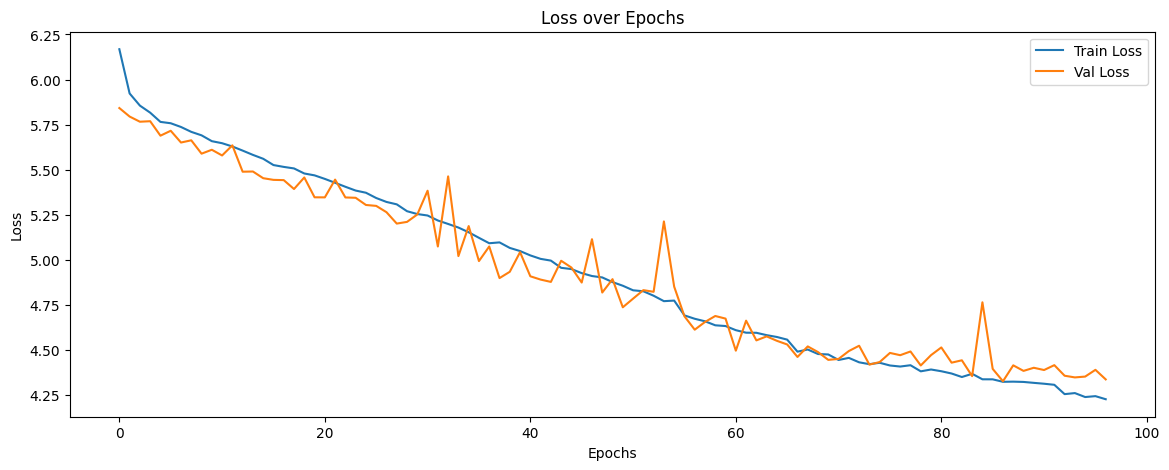

In [ ]:
plt.figure(figsize=(14, 5))

plt.plot(_2.history['loss'], label='Train Loss')
plt.plot(_2.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


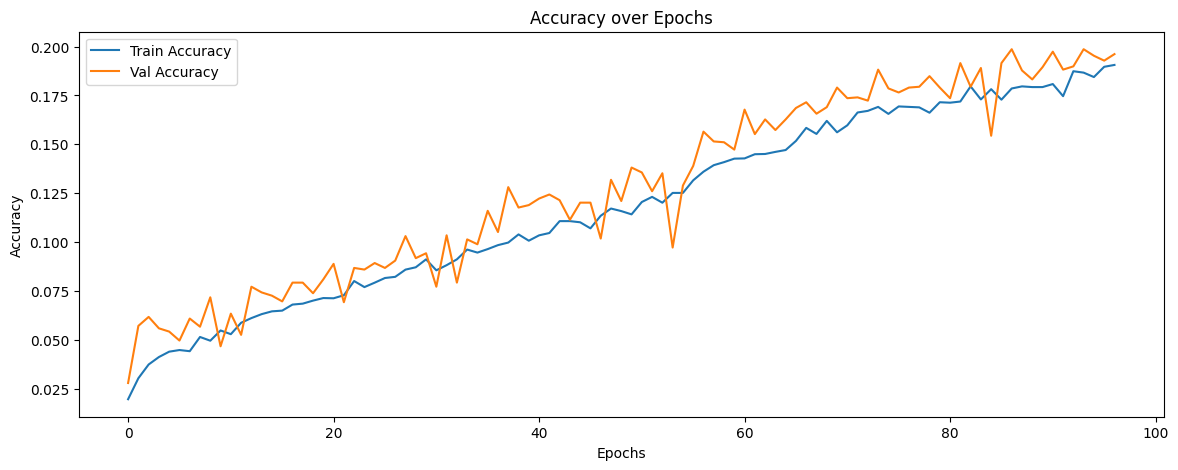

In [ ]:
plt.figure(figsize=(14, 5))

# Plot accuracy
plt.plot(_2.history['accuracy'], label='Train Accuracy')
plt.plot(_2.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


plt.show()

## Eficient Net V2S

### First Model

In [ ]:
def build_efficientnetv2s_model(input_shape=input_shape, num_classes=num_classes):
    inputs = Input(shape=input_shape, name="input_layer")
    x = augmentation_layer(inputs)
    base_model = EfficientNetV2S(
        include_top=False,
        weights="imagenet",
        input_shape=input_shape,
        include_preprocessing=True
    )

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    output = Dense(num_classes, activation="softmax")(x)
    
    base_model.trainable = False  # Freeze the base model

    model = Model(inputs=base_model.input, outputs=output, name="EfficientNetV2S_Custom")
    return model


In [ ]:
effnet = build_efficientnetv2s_model(input_shape=input_shape, num_classes=num_classes)
# effnet.summary()

metrics = [
    CategoricalAccuracy(name="accuracy"),
    TopKCategoricalAccuracy(k=5, name="top_5_accuracy"),
    F1Score(name="f1_score", average="macro")
]

effnet.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=CategoricalCrossentropy(),
    metrics=metrics)


2025-04-27 00:41:44.040555: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:501] Allocator (GPU_0_bfc) ran out of memory trying to allocate 8B (rounded to 256)requested by op Cast
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2025-04-27 00:41:44.040743: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1058] BFCAllocator dump for GPU_0_bfc
2025-04-27 00:41:44.040752: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1065] Bin (256): 	Total Chunks: 1500, Chunks in use: 1500. 375.0KiB allocated for chunks. 375.0KiB in use in bin. 96.0KiB client-requested in use in bin.
2025-04-27 00:41:44.040756: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1065] Bin (512): 	Total Chunks: 412, Chunks in use: 412. 229.8KiB allocated for chunks. 229.8KiB in use in bin. 210.2KiB client-requested in use in bin.
2025-04-2

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run Cast: Dst tensor is not initialized. [Op:Cast] name: 

In [ ]:
checkpoint_cb = ModelCheckpoint(
    filepath='efficientnetv2s_best_model.weights.h5',  # keras or .h5
    monitor='val_loss',                    
    save_best_only=True,
    save_weights_only=True,                   # True = only weights, False = full model
    verbose=1
)


In [ ]:
_3 = effnet.fit(
    train_df,
    validation_data=val_df,
    epochs=200,
    callbacks=[early_stop, lr_reduction, checkpoint_cb],
    verbose=1
)

Epoch 1/200
516/516 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.0335 - f1_score: 0.0111 - loss: 5.2230 - top_5_accuracy: 0.0853
Epoch 1: val_loss improved from inf to 4.46289, saving model to efficientnetv2s_best_model.weights.h5
516/516 ━━━━━━━━━━━━━━━━━━━━ 664s 1s/step - accuracy: 0.0335 - f1_score: 0.0111 - loss: 5.2225 - top_5_accuracy: 0.0854 - val_accuracy: 0.1501 - val_f1_score: 0.0432 - val_loss: 4.4629 - val_top_5_accuracy: 0.3189 - learning_rate: 1.0000e-04
Epoch 2/200
516/516 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1543 - f1_score: 0.0461 - loss: 4.2702 - top_5_accuracy: 0.3371
Epoch 2: val_loss improved from 4.46289 to 3.71196, saving model to efficientnetv2s_best_model.weights.h5
516/516 ━━━━━━━━━━━━━━━━━━━━ 661s 1s/step - accuracy: 0.1543 - f1_score: 0.0461 - loss: 4.2699 - top_5_accuracy: 0.3372 - val_accuracy: 0.2375 - val_f1_score: 0.0966 - val_loss: 3.7120 - val_top_5_accuracy: 0.4601 - learning_rate: 1.0000e-04
Epoch 3/200
516/516 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/s

In [ ]:
ef_eva1 = _3.evaluate(val_df, verbose=1)

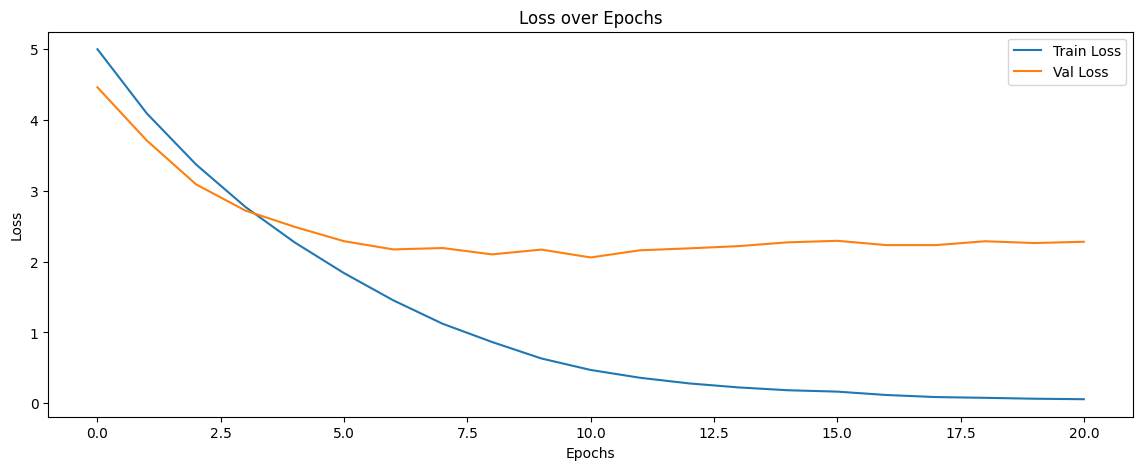

In [ ]:

plt.figure(figsize=(14, 5))

# Plot loss
plt.plot(_3.history['loss'], label='Train Loss')
plt.plot(_3.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show() 

In [ ]:
y_prob = effnet.predict(val_df, verbose=1)      # shape: (N, 202)
y_pred = np.argmax(y_prob, axis=1)               # predicted class ids

148/148 ━━━━━━━━━━━━━━━━━━━━ 30s 194ms/step


In [ ]:
y_true = val['target'].values                    

assert len(y_true) == len(y_pred), "mismatch in lengths!"

In [ ]:
target_names = label_encoder.classes_

report_df = (
    pd.DataFrame(
        classification_report(
            y_true,
            y_pred,
            target_names=target_names,
            output_dict=True,
            zero_division=0
        )
    )
    .transpose()
    .drop(index=["accuracy", "macro avg", "weighted avg"])
    .sort_values("recall")              
)

pd.set_option("display.max_rows", None)
display(report_df)               


precision    recall  f1-score  support
accipitridae        0.000000  0.000000  0.000000     23.0
acipenseridae       0.000000  0.000000  0.000000     18.0
agamidae            0.000000  0.000000  0.000000     12.0
agariciidae         0.000000  0.000000  0.000000     24.0
alcedinidae         0.000000  0.000000  0.000000      6.0
albulidae           0.000000  0.000000  0.000000      6.0
alligatoridae       0.000000  0.000000  0.000000      6.0
alopiidae           0.000000  0.000000  0.000000     12.0
arthroleptidae      0.000000  0.000000  0.000000      6.0
ambystomatidae      0.000000  0.000000  0.000000     10.0
ardeidae            0.000000  0.000000  0.000000     12.0
aotidae             0.000000  0.000000  0.000000     12.0
balaenidae          0.000000  0.000000  0.000000      6.0
balaenicipitidae    0.000000  0.000000  0.000000      6.0
attelabidae         0.000000  0.000000  0.000000      6.0
atelidae            0.000000  0.000000  0.000000     30.0
cacatuidae          0.000000  0.000000  0.000000      6.0
bucerotidae         0.000000  0.000000  0.000000     40.0
bufonidae           0.000000  0.000000  0.000000     30.0
burhinidae          0.000000  0.000000  0.000000     12.0
balaenopteridae     0.000000  0.000000  0.000000      6.0
balistidae          0.000000  0.000000  0.000000     12.0
bombycillidae       0.000000  0.000000  0.000000      6.0
brachypteraciidae   0.000000  0.000000  0.000000      6.0
callorhinchidae     0.000000  0.000000  0.000000      6.0
callitrichidae      0.000000  0.000000  0.000000     24.0
caprimulgidae       0.000000  0.000000  0.000000      6.0
cervidae            0.000000  0.000000  0.000000      6.0
cebidae             0.000000  0.000000  0.000000     18.0
carettochelyidae    0.000000  0.000000  0.000000      6.0
cardiidae           0.000000  0.000000  0.000000     12.0
carabidae           0.000000  0.000000  0.000000     12.0
dalatiidae          0.000000  0.000000  0.000000      6.0
ctenomyidae         0.000000  0.000000  0.000000      6.0
cuculidae           0.000000  0.000000  0.000000      6.0
columbidae          0.000000  0.000000  0.000000      6.0
conidae             0.000000  0.000000  0.000000      5.0
cerambycidae        0.000000  0.000000  0.000000      6.0
chaetodontidae      0.000000  0.000000  0.000000     12.0
cetorhinidae        0.000000  0.000000  0.000000      6.0
cheloniidae         0.000000  0.000000  0.000000      6.0
chelidae            0.000000  0.000000  0.000000     11.0
charadriidae        0.000000  0.000000  0.000000     12.0
cheirogaleidae      0.000000  0.000000  0.000000      6.0
chelydridae         0.000000  0.000000  0.000000      6.0
colubridae          0.000000  0.000000  0.000000     17.0
coenagrionidae      0.000000  0.000000  0.000000      6.0
ciconiidae          0.000000  0.000000  0.000000     18.0
dasypodidae         0.000000  0.000000  0.000000      6.0
cyprinodontidae     0.000000  0.000000  0.000000      6.0
crocodylidae        0.000000  0.000000  0.000000     12.0
cryptobranchidae    0.000000  0.000000  0.000000     12.0
cricetidae          0.000000  0.000000  0.000000      6.0
equidae             0.000000  0.000000  0.000000      6.0
emydidae            0.000000  0.000000  0.000000     12.0
euphylliidae        0.000000  0.000000  0.000000     18.0
elapidae            0.000000  0.000000  0.000000      6.0
diplodactylidae     0.000000  0.000000  0.000000     12.0
diploastraeidae     0.000000  0.000000  0.000000      6.0
dendrophylliidae    0.000000  0.000000  0.000000      6.0
dendrobatidae       0.000000  0.000000  0.000000      6.0
delphinidae         0.000000  0.000000  0.000000     24.0
daubentoniidae      0.000000  0.000000  0.000000      6.0
dasyuridae          0.000000  0.000000  0.000000      6.0
muscicapidae        0.000000  0.000000  0.000000      4.0
mustelidae          0.000000  0.000000  0.000000     18.0
megapodiidae        0.000000  0.000000  0.000000      6.0
indriidae           0.000000  0.000000  0.000000      6.0
lacertidae       

Let's add some weights to the classes that are having trouble in the predictions

### Second Model

With bias and class weight

In [ ]:
# adding bias as seen in the tensorflow website https://www.tensorflow.org/tutorials/structured_data/imbalanced_data


# Count images per class
counts = clean_metadata['target'].value_counts().sort_index()  # must be sorted to match class indices
total = np.sum(counts)

# Compute log priors
initial_bias = np.log(counts / total)


In [ ]:
def build_efficientnetv2s_model(input_shape=input_shape, num_classes=num_classes):
    inputs = Input(shape=input_shape, name="input_layer")
    x = augmentation_layer(inputs)
    base_model = EfficientNetV2S(
        include_top=False,
        weights="imagenet",
        input_shape=input_shape,
        include_preprocessing=True
    )

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    output = Dense(num_classes, activation="softmax",bias_initializer= Constant(initial_bias))(x)

    model = Model(inputs=base_model.input, outputs=output, name="EfficientNetV2S_Custom")
    return model


In [ ]:
effnet_v2 = build_efficientnetv2s_model(input_shape=input_shape, num_classes=num_classes)
#effnet_v2.summary()

metrics = [
    CategoricalAccuracy(name="accuracy"),
    TopKCategoricalAccuracy(k=5, name="top_5_accuracy"),
    F1Score(name="f1_score", average="macro")
]

effnet_v2.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=CategoricalCrossentropy(),
    metrics=metrics)


In [ ]:
lr_reduction = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=0, verbose = 1)

early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5, restore_best_weights = True)

In [ ]:
checkpoint_cb = ModelCheckpoint(
    filepath='efficientnetv2s_best_model.weights.h5',  # keras or .h5
    monitor='val_loss',                    
    save_best_only=True,
    save_weights_only=True,                   # True = only weights, False = full model
    verbose=1
)


In [ ]:
_4 = effnet_v2.fit(
    train_df,
    validation_data=val_df,
    epochs=200,
    callbacks=[early_stop, lr_reduction, checkpoint_cb],
    verbos e=1,
    #class_weight=class_weights_dict
)

NameError: name 'class_weights_dict' is not defined

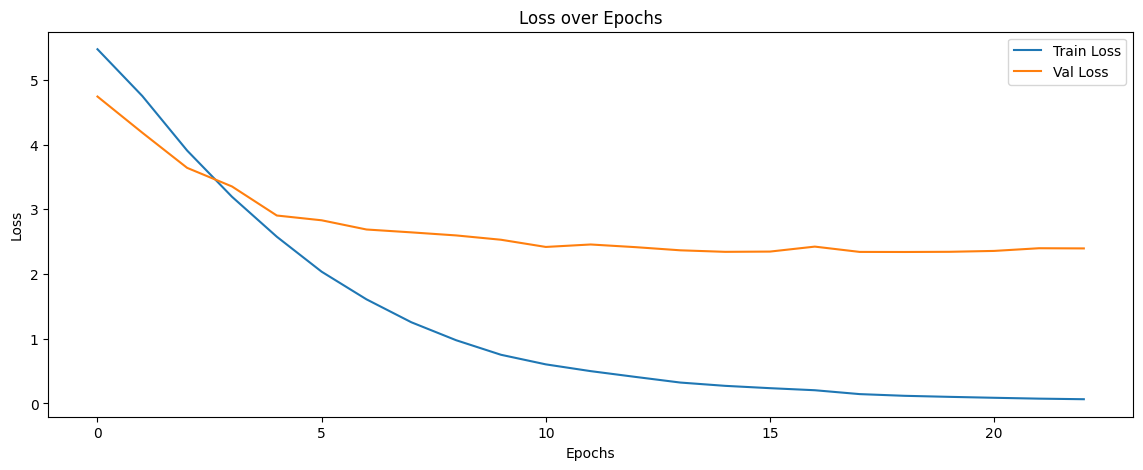

In [ ]:

plt.figure(figsize=(14, 5))

# Plot loss
plt.plot(_4.history['loss'], label='Train Loss')
plt.plot(_4.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show() 

In [ ]:
y_prob = effnet_v2.predict(val_df, verbose=1)      # shape: (N, 202)
y_pred = np.argmax(y_prob, axis=1)               # predicted class ids

74/74 ━━━━━━━━━━━━━━━━━━━━ 15s 198ms/step


In [ ]:
y_true = val['target'].values                    

assert len(y_true) == len(y_pred), "mismatch in lengths!"

In [ ]:
report = classification_report(
    y_true,
    y_pred,
    target_names=label_encoder.classes_,
    output_dict=True,
    zero_division=0
)

# Convert to DataFrame
report_df = pd.DataFrame(report).transpose()

# Calculate top-5 accuracy separately
top5_acc = top_k_accuracy_score(y_true, y_prob, k=5)

# Keep only 'f1-score' column
report_df = report_df[['f1-score']]  

# Insert top-5 manually
report_df.loc['top_5_accuracy'] = [top5_acc]

# Insert overall accuracy manually (global accuracy)
overall_accuracy = (y_true == y_pred).mean()
report_df.loc['accuracy'] = [overall_accuracy]

# Clean display
pd.set_option('display.max_rows', None)
display(report_df)

f1-score
accipitridae       0.222222
acipenseridae      0.400000
acroporidae        0.648649
agamidae           0.615385
agariciidae        0.666667
albulidae          0.000000
alcedinidae        0.666667
alligatoridae      0.333333
alopiidae          0.333333
ambystomatidae     0.222222
anatidae           0.344828
anguidae           0.461538
aotidae            0.769231
apidae             0.965517
ardeidae           0.666667
arthroleptidae     0.500000
atelidae           0.500000
attelabidae        1.000000
balaenicipitidae   0.500000
balaenidae         0.153846
balaenopteridae    0.400000
balistidae         0.615385
bombycillidae      0.750000
bovidae            0.488889
brachypteraciidae  0.571429
bucerotidae        0.651163
bufonidae          0.666667
burhinidae         0.444444
cacatuidae         0.666667
callitrichidae     0.400000
callorhinchidae    0.000000
caprimulgidae      0.000000
carabidae          0.545455
carcharhinidae     0.641509
cardiidae          0.333333
carettochelyidae   0.000000
cebidae            0.631579
cerambycidae       1.000000
cercopithecidae    0.526316
cervidae           0.000000
cetorhinidae       0.285714
chaetodontidae     1.000000
chamaeleonidae     0.400000
charadriidae       0.545455
cheirogaleidae     0.857143
chelidae           0.545455
cheloniidae        0.333333
chelydridae        0.000000
ciconiidae         0.416667
coenagrionidae     0.750000
colubridae         0.600000
columbidae         0.400000
conidae            0.800000
cracidae           0.307692
cricetidae         0.571429
crocodylidae       0.545455
cryptobranchidae   0.333333
ctenomyidae        0.571429
cuculidae          0.500000
cyprinodontidae    0.400000
dactyloidae        0.721311
dalatiidae         0.000000
dasyatidae         0.600000
dasypodidae        0.600000
dasyuridae         0.000000
daubentoniidae     0.000000
delphinidae        0.592593
dendrobatidae      0.444444
dendrophylliidae   0.333333
diomedeidae        0.545455
diploastraeidae    0.500000
diplodactylidae    0.307692
elapidae           0.000000
emydidae           0.727273
equidae            0.800000
estrildidae        0.800000
euphylliidae       0.416667
falconidae         0.545455
faviidae           0.333333
formicidae         0.909091
fringillidae       0.461538
fungiidae          0.750000
gavialidae         0.285714
gekkonidae         0.800000
geoemydidae        0.266667
giraffidae         0.800000
glareolidae        0.400000
gliridae           0.000000
gomphidae          0.833333
goodeidae          1.000000
gymnuridae         0.333333
haliotidae         1.000000
helioporidae       0.000000
hemiscylliidae     0.800000
hexanchidae        0.400000
hominidae          0.750000
hyaenidae          0.285714
hylobatidae        0.500000
hynobiidae         0.000000
iguanidae          0.526316
indriidae          0.333333
labridae           0.666667
lacertidae         0.400000
lamnidae           0.000000
laridae            0.611111
latimeriidae       0.666667
lemuridae          0.533333
leporidae          0.000000
lobophylliidae     0.666667
lucanidae          0.857143
lutjanidae         0.000000
manidae            0.500000
mantellidae        0.250000
meandrinidae       1.000000
megapodiidae       0.285714
merlucciidae       0.333333
merulinidae        0.333333
mesitornithidae    0.500000
mimidae            0.800000
motacillidae       0.333333
muscicapidae       0.000000
mustelidae         0.250000
myliobatidae       0.400000
nesospingidae      0.285714
nymphalidae        0.750000
odontophoridae     0.800000
otariidae          0.333333
otididae           0.857143
palinuridae        1.000000
pangasiidae        0.750000
papilionidae       0.500000
paradisaeidae      0.800000
pardalotidae       0.666667
parulidae          0.000000
percidae           0.571429
phasianidae        0.333333
phrynosomatidae    0.000000
phyllomedusidae    0.500000
phyllostomidae     0.285714
pisauridae         0.857143
pittidae           0.666667
platystictidae     0.571429
plethodontidae 

In [ ]:
# target_names = label_encoder.classes_

# report_df = (
#     pd.DataFrame(
#         classification_report(
#             y_true,
#             y_pred,
#             target_names=target_names,
#             output_dict=True,
#             zero_division=0
#         )
#     )
#     .transpose()
#     .drop(index=["accuracy", "macro avg", "weighted avg"])
#     .sort_values("recall")              
# )

# pd.set_option("display.max_rows", None)
# display(report_df.head(202))               


In [ ]:
effnet_v3 = build_efficientnetv2s_model(input_shape=input_shape, num_classes=num_classes)
#effnet_v2.summary()

metrics = [
    CategoricalAccuracy(name="accuracy"),
    TopKCategoricalAccuracy(k=5, name="top_5_accuracy"),
    F1Score(name="f1_score", average="macro")
]

effnet_v3.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=CategoricalCrossentropy(),
    metrics=metrics)


In [ ]:
_5 = effnet_v3.fit(
    train_df,
    validation_data=val_df,
    epochs=200,
    callbacks=[early_stop, lr_reduction, checkpoint_cb],
    verbose=1,
    #class_weight=class_weights_dict 
)

Epoch 1/200
  2/520 ━━━━━━━━━━━━━━━━━━━━ 10:42 1s/step - accuracy: 0.0469 - f1_score: 0.0050 - loss: 4.9818 - top_5_accuracy: 0.0469

2025-04-26 15:16:17.630277: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:501] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.59MiB (rounded to 4816896)requested by op Sigmoid
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2025-04-26 15:16:17.631208: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1058] BFCAllocator dump for GPU_0_bfc
2025-04-26 15:16:17.631215: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1065] Bin (256): 	Total Chunks: 8080, Chunks in use: 8080. 1.97MiB allocated for chunks. 1.97MiB in use in bin. 153.8KiB client-requested in use in bin.
2025-04-26 15:16:17.631220: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1065] Bin (512): 	Total Chunks: 659, Chunks in use: 657. 432.5KiB allocated for chunks. 431.2KiB in use in bin. 376.6KiB client-requested in use in bin

ResourceExhaustedError: Exception encountered when calling Activation.call().

[1m{{function_node __wrapped__Sigmoid_device_/job:localhost/replica:0/task:0/device:GPU:0}} failed to allocate memory [Op:Sigmoid] name: [0m

Arguments received by Activation.call():
  • inputs=tf.Tensor(shape=(16, 7, 7, 1536), dtype=float32)

In [ ]:
env3_eva = effnet_v3.evaluate(val_df, verbose=1)

148/148 ━━━━━━━━━━━━━━━━━━━━ 32s 208ms/step - accuracy: 0.5348 - f1_score: 0.4425 - loss: 2.1870 - top_5_accuracy: 0.7528


In [ ]:
y_prob = effnet_v3.predict(val_df, verbose=1)      # shape: (N, 202)
y_pred = np.argmax(y_prob, axis=1)               # predicted class ids

148/148 ━━━━━━━━━━━━━━━━━━━━ 31s 197ms/step


In [ ]:
y_true = val['target'].values                    

assert len(y_true) == len(y_pred), "mismatch in lengths!"

In [ ]:
target_names = label_encoder.classes_

report_df = (
    pd.DataFrame(
        classification_report(
            y_true,
            y_pred,
            target_names=target_names,
            output_dict=True,
            zero_division=0
        )
    )
    .transpose()
    .drop(index=["accuracy", "macro avg", "weighted avg"])
    .sort_values("recall")              
)

pd.set_option("display.max_rows", None)
display(report_df.head(202))               


precision    recall  f1-score  support
accipitridae        0.000000  0.000000  0.000000     23.0
acipenseridae       0.000000  0.000000  0.000000     18.0
acroporidae         0.000000  0.000000  0.000000     42.0
agariciidae         0.000000  0.000000  0.000000     24.0
alcedinidae         0.000000  0.000000  0.000000      6.0
albulidae           0.000000  0.000000  0.000000      6.0
alligatoridae       0.000000  0.000000  0.000000      6.0
alopiidae           0.000000  0.000000  0.000000     12.0
arthroleptidae      0.000000  0.000000  0.000000      6.0
ambystomatidae      0.000000  0.000000  0.000000     10.0
anguidae            0.000000  0.000000  0.000000     12.0
aotidae             0.000000  0.000000  0.000000     12.0
ardeidae            0.000000  0.000000  0.000000     12.0
balaenidae          0.000000  0.000000  0.000000      6.0
balaenicipitidae    0.000000  0.000000  0.000000      6.0
attelabidae         0.000000  0.000000  0.000000      6.0
callorhinchidae     0.000000  0.000000  0.000000      6.0
bufonidae           0.000000  0.000000  0.000000     30.0
callitrichidae      0.000000  0.000000  0.000000     24.0
balaenopteridae     0.000000  0.000000  0.000000      6.0
bombycillidae       0.000000  0.000000  0.000000      6.0
balistidae          0.000000  0.000000  0.000000     12.0
bovidae             0.000000  0.000000  0.000000     48.0
brachypteraciidae   0.000000  0.000000  0.000000      6.0
caprimulgidae       0.000000  0.000000  0.000000      6.0
cacatuidae          0.000000  0.000000  0.000000      6.0
charadriidae        0.000000  0.000000  0.000000     12.0
cheirogaleidae      0.000000  0.000000  0.000000      6.0
cheloniidae         0.000000  0.000000  0.000000      6.0
cervidae            0.000000  0.000000  0.000000      6.0
cardiidae           0.000000  0.000000  0.000000     12.0
carettochelyidae    0.000000  0.000000  0.000000      6.0
cryptobranchidae    0.000000  0.000000  0.000000     12.0
ctenomyidae         0.000000  0.000000  0.000000      6.0
cuculidae           0.000000  0.000000  0.000000      6.0
cyprinodontidae     0.000000  0.000000  0.000000      6.0
dalatiidae          0.000000  0.000000  0.000000      6.0
dasyatidae          0.000000  0.000000  0.000000     29.0
chaetodontidae      0.000000  0.000000  0.000000     12.0
cetorhinidae        0.000000  0.000000  0.000000      6.0
chelydridae         0.000000  0.000000  0.000000      6.0
chelidae            0.000000  0.000000  0.000000     11.0
cracidae            0.000000  0.000000  0.000000     11.0
conidae             0.000000  0.000000  0.000000      5.0
columbidae          0.000000  0.000000  0.000000      6.0
colubridae          0.000000  0.000000  0.000000     17.0
coenagrionidae      0.000000  0.000000  0.000000      6.0
ciconiidae          0.000000  0.000000  0.000000     18.0
dasypodidae         0.000000  0.000000  0.000000      6.0
crocodylidae        0.000000  0.000000  0.000000     12.0
cricetidae          0.000000  0.000000  0.000000      6.0
euphylliidae        0.000000  0.000000  0.000000     18.0
estrildidae         0.000000  0.000000  0.000000      6.0
equidae             0.000000  0.000000  0.000000      6.0
emydidae            0.000000  0.000000  0.000000     12.0
elapidae            0.000000  0.000000  0.000000      6.0
diplodactylidae     0.000000  0.000000  0.000000     12.0
diploastraeidae     0.000000  0.000000  0.000000      6.0
diomedeidae         0.000000  0.000000  0.000000     36.0
dendrophylliidae    0.000000  0.000000  0.000000      6.0
dendrobatidae       0.000000  0.000000  0.000000      6.0
delphinidae         0.000000  0.000000  0.000000     24.0
daubentoniidae      0.000000  0.000000  0.000000      6.0
dasyuridae          0.000000  0.000000  0.000000      6.0
mantellidae         0.000000  0.000000  0.000000      6.0
hylobatidae         0.000000  0.000000  0.000000     18.0
hynobiidae          0.000000  0.000000  0.000000      6.0
iguanidae           0.000000  0.000000  0.000000     22.0
indriidae        

## ResNet50

In [ ]:
from keras.layers import Activation

In [ ]:
# resnet50 = Sequential()

# resnet50.add(augmentation_layer)

# #Layer 1: RES50 without top layer
# resnet50.add(ResNet50(weights='imagenet', input_shape= input_shape ,include_top = False, classes=num_classes,))

# #Passing it to the next layer

# resnet50.add(GlobalAveragePooling2D())


# # 1st Fully Connected Layer
# resnet50.add(Dense(2048))
# resnet50.add(BatchNormalization())
# resnet50.add(Activation('relu'))
# # Add Dropout to prevent overfitting
# resnet50.add(Dropout(0.4))

# #2nd Fully Connected Layer
# resnet50.add(Dense(1024))
# resnet50.add(BatchNormalization())
# resnet50.add(Activation('relu'))

# #Add Dropout
# resnet50.add(Dropout(0.4))

# resnet50.add(Dense(num_classes, activation = 'softmax', bias_initializer= Constant(initial_bias)))

# #freeze layers in resnet - weights obtained with IMAGENET challenge, we only train final layer
# resnet50.layers[1].trainable = False

# resnet50.summary()

In [ ]:
from tensorflow.keras import mixed_precision

mixed_precision.set_global_policy('mixed_float16')


In [ ]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

inputs = tf.keras.Input(shape=input_shape)
x = augmentation_layer(inputs)

base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_tensor=x
)
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.4)(x)
x = Dense(256)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.4)(x)

# Important: output Dense must be float32
outputs = Dense(num_classes, activation='softmax', dtype='float32')(x)

resnet50 = Model(inputs, outputs)



2025-04-27 00:28:54.250044: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:501] Allocator (GPU_0_bfc) ran out of memory trying to allocate 36.8KiB (rounded to 37632)requested by op StatelessRandomUniformV2
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2025-04-27 00:28:54.250228: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1058] BFCAllocator dump for GPU_0_bfc
2025-04-27 00:28:54.250234: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1065] Bin (256): 	Total Chunks: 1473, Chunks in use: 1473. 368.2KiB allocated for chunks. 368.2KiB in use in bin. 93.8KiB client-requested in use in bin.
2025-04-27 00:28:54.250238: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1065] Bin (512): 	Total Chunks: 412, Chunks in use: 412. 229.8KiB allocated for chunks. 229.8KiB in use in bin. 210.2KiB client-request

ResourceExhaustedError: {{function_node __wrapped__StatelessRandomUniformV2_device_/job:localhost/replica:0/task:0/device:GPU:0}} OOM when allocating tensor with shape[7,7,3,64] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:StatelessRandomUniformV2] name: 

In [ ]:
metrics = [
    CategoricalAccuracy(name="accuracy"),
    TopKCategoricalAccuracy(k=5, name="top_5_accuracy"),
    F1Score(name="f1_score", average="macro")
]

resnet50.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=CategoricalCrossentropy(),
    metrics=metrics)


In [ ]:
_9 = resnet50.fit(
    train_df,
    validation_data=val_df,
    epochs=200,
    callbacks=[early_stop, lr_reduction, checkpoint_cb],
    verbose=1,
    #class_weight=class_weights_dict 
)

Epoch 1/200


2025-04-27 00:21:12.514014: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:501] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.30MiB (rounded to 2408448)requested by op Minimum
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2025-04-27 00:21:12.514201: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1058] BFCAllocator dump for GPU_0_bfc
2025-04-27 00:21:12.514207: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1065] Bin (256): 	Total Chunks: 1426, Chunks in use: 1422. 356.5KiB allocated for chunks. 355.5KiB in use in bin. 87.3KiB client-requested in use in bin.
2025-04-27 00:21:12.514210: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1065] Bin (512): 	Total Chunks: 412, Chunks in use: 412. 229.8KiB allocated for chunks. 229.8KiB in use in bin. 210.2KiB client-requested in use in bi

ResourceExhaustedError: Exception encountered when calling RandomBrightness.call().

[1m{{function_node __wrapped__Minimum_device_/job:localhost/replica:0/task:0/device:GPU:0}} failed to allocate memory [Op:Minimum] name: [0m

Arguments received by RandomBrightness.call():
  • data=tf.Tensor(shape=(4, 224, 224, 3), dtype=float32)
  • training=True

In [ ]:
rn50_eva = resnet50.evaluate(val_df, verbose=1)

148/148 ━━━━━━━━━━━━━━━━━━━━ 32s 208ms/step - accuracy: 0.5348 - f1_score: 0.4425 - loss: 2.1870 - top_5_accuracy: 0.7528


In [ ]:
y_prob = resnet50.predict(val_df, verbose=1)      # shape: (N, 202)
y_pred = np.argmax(y_prob, axis=1)               # predicted class ids

148/148 ━━━━━━━━━━━━━━━━━━━━ 31s 197ms/step


In [ ]:
y_true = val['target'].values                    

assert len(y_true) == len(y_pred), "mismatch in lengths!"

In [ ]:
target_names = label_encoder.classes_

report_df = (
    pd.DataFrame(
        classification_report(
            y_true,
            y_pred,
            target_names=target_names,
            output_dict=True,
            zero_division=0
        )
    )
    .transpose()
    .drop(index=["accuracy", "macro avg", "weighted avg"])
    .sort_values("recall")              
)

pd.set_option("display.max_rows", None)
display(report_df.head(202))               


precision    recall  f1-score  support
accipitridae        0.000000  0.000000  0.000000     23.0
acipenseridae       0.000000  0.000000  0.000000     18.0
acroporidae         0.000000  0.000000  0.000000     42.0
agariciidae         0.000000  0.000000  0.000000     24.0
alcedinidae         0.000000  0.000000  0.000000      6.0
albulidae           0.000000  0.000000  0.000000      6.0
alligatoridae       0.000000  0.000000  0.000000      6.0
alopiidae           0.000000  0.000000  0.000000     12.0
arthroleptidae      0.000000  0.000000  0.000000      6.0
ambystomatidae      0.000000  0.000000  0.000000     10.0
anguidae            0.000000  0.000000  0.000000     12.0
aotidae             0.000000  0.000000  0.000000     12.0
ardeidae            0.000000  0.000000  0.000000     12.0
balaenidae          0.000000  0.000000  0.000000      6.0
balaenicipitidae    0.000000  0.000000  0.000000      6.0
attelabidae         0.000000  0.000000  0.000000      6.0
callorhinchidae     0.000000  0.000000  0.000000      6.0
bufonidae           0.000000  0.000000  0.000000     30.0
callitrichidae      0.000000  0.000000  0.000000     24.0
balaenopteridae     0.000000  0.000000  0.000000      6.0
bombycillidae       0.000000  0.000000  0.000000      6.0
balistidae          0.000000  0.000000  0.000000     12.0
bovidae             0.000000  0.000000  0.000000     48.0
brachypteraciidae   0.000000  0.000000  0.000000      6.0
caprimulgidae       0.000000  0.000000  0.000000      6.0
cacatuidae          0.000000  0.000000  0.000000      6.0
charadriidae        0.000000  0.000000  0.000000     12.0
cheirogaleidae      0.000000  0.000000  0.000000      6.0
cheloniidae         0.000000  0.000000  0.000000      6.0
cervidae            0.000000  0.000000  0.000000      6.0
cardiidae           0.000000  0.000000  0.000000     12.0
carettochelyidae    0.000000  0.000000  0.000000      6.0
cryptobranchidae    0.000000  0.000000  0.000000     12.0
ctenomyidae         0.000000  0.000000  0.000000      6.0
cuculidae           0.000000  0.000000  0.000000      6.0
cyprinodontidae     0.000000  0.000000  0.000000      6.0
dalatiidae          0.000000  0.000000  0.000000      6.0
dasyatidae          0.000000  0.000000  0.000000     29.0
chaetodontidae      0.000000  0.000000  0.000000     12.0
cetorhinidae        0.000000  0.000000  0.000000      6.0
chelydridae         0.000000  0.000000  0.000000      6.0
chelidae            0.000000  0.000000  0.000000     11.0
cracidae            0.000000  0.000000  0.000000     11.0
conidae             0.000000  0.000000  0.000000      5.0
columbidae          0.000000  0.000000  0.000000      6.0
colubridae          0.000000  0.000000  0.000000     17.0
coenagrionidae      0.000000  0.000000  0.000000      6.0
ciconiidae          0.000000  0.000000  0.000000     18.0
dasypodidae         0.000000  0.000000  0.000000      6.0
crocodylidae        0.000000  0.000000  0.000000     12.0
cricetidae          0.000000  0.000000  0.000000      6.0
euphylliidae        0.000000  0.000000  0.000000     18.0
estrildidae         0.000000  0.000000  0.000000      6.0
equidae             0.000000  0.000000  0.000000      6.0
emydidae            0.000000  0.000000  0.000000     12.0
elapidae            0.000000  0.000000  0.000000      6.0
diplodactylidae     0.000000  0.000000  0.000000     12.0
diploastraeidae     0.000000  0.000000  0.000000      6.0
diomedeidae         0.000000  0.000000  0.000000     36.0
dendrophylliidae    0.000000  0.000000  0.000000      6.0
dendrobatidae       0.000000  0.000000  0.000000      6.0
delphinidae         0.000000  0.000000  0.000000     24.0
daubentoniidae      0.000000  0.000000  0.000000      6.0
dasyuridae          0.000000  0.000000  0.000000      6.0
mantellidae         0.000000  0.000000  0.000000      6.0
hylobatidae         0.000000  0.000000  0.000000     18.0
hynobiidae          0.000000  0.000000  0.000000      6.0
iguanidae           0.000000  0.000000  0.000000     22.0
indriidae        

### EfficientNetB6

In [ ]:
from keras.applications import EfficientNetB0

In [ ]:


EffNetB0model = Sequential()


EffNetB0model.add(augmentation_layer)
#Layer 1

EffNetB0model.add(EfficientNetB0(weights='imagenet', input_shape=input_shape,include_top = False))
EffNetB0model.add(layers.GlobalMaxPooling2D(name="gap")) 
#EffNetB6.add(Flatten())

# 1st Fully Connected Layer
EffNetB0model.add(Dense(2560))
EffNetB0model.add(BatchNormalization())
EffNetB0model.add(Activation('relu'))

# Add Dropout to prevent overfitting
EffNetB0model.add(Dropout(0.4))

#2nd Fully Connected Layer
EffNetB0model.add(Dense(1280))
EffNetB0model.add(BatchNormalization())
EffNetB0model.add(Activation('relu'))

EffNetB0model.add(Dropout(0.2))

EffNetB0model.add(Dense(num_classes, activation="softmax", bias_initializer= Constant(initial_bias)))

#EffNetB0model.layers[0].trainable = False

2025-04-27 00:34:44.923976: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:501] Allocator (GPU_0_bfc) ran out of memory trying to allocate 12B (rounded to 256)requested by op Fill
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2025-04-27 00:34:44.924161: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1058] BFCAllocator dump for GPU_0_bfc
2025-04-27 00:34:44.924171: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1065] Bin (256): 	Total Chunks: 1500, Chunks in use: 1500. 375.0KiB allocated for chunks. 375.0KiB in use in bin. 96.0KiB client-requested in use in bin.
2025-04-27 00:34:44.924173: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1065] Bin (512): 	Total Chunks: 412, Chunks in use: 412. 229.8KiB allocated for chunks. 229.8KiB in use in bin. 210.2KiB client-requested in use in bin.
2025-04-

ResourceExhaustedError: {{function_node __wrapped__Fill_device_/job:localhost/replica:0/task:0/device:GPU:0}} OOM when allocating tensor with shape[3] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Fill] name: 

In [ ]:
metrics = [
    CategoricalAccuracy(name="accuracy"),
    TopKCategoricalAccuracy(k=5, name="top_5_accuracy"),
    F1Score(name="f1_score", average="macro")
]

EffNetB6model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=CategoricalCrossentropy(),
    metrics=metrics)


In [ ]:
_10 = EffNetB6model.fit(
    train_df,
    validation_data=val_df,
    epochs=200,
    callbacks=[early_stop, lr_reduction, checkpoint_cb],
    verbose=1,
    #class_weight=class_weights_dict 
)

Epoch 1/200
  2/520 ━━━━━━━━━━━━━━━━━━━━ 10:42 1s/step - accuracy: 0.0469 - f1_score: 0.0050 - loss: 4.9818 - top_5_accuracy: 0.0469

2025-04-26 15:16:17.630277: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:501] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.59MiB (rounded to 4816896)requested by op Sigmoid
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2025-04-26 15:16:17.631208: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1058] BFCAllocator dump for GPU_0_bfc
2025-04-26 15:16:17.631215: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1065] Bin (256): 	Total Chunks: 8080, Chunks in use: 8080. 1.97MiB allocated for chunks. 1.97MiB in use in bin. 153.8KiB client-requested in use in bin.
2025-04-26 15:16:17.631220: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1065] Bin (512): 	Total Chunks: 659, Chunks in use: 657. 432.5KiB allocated for chunks. 431.2KiB in use in bin. 376.6KiB client-requested in use in bin

ResourceExhaustedError: Exception encountered when calling Activation.call().

[1m{{function_node __wrapped__Sigmoid_device_/job:localhost/replica:0/task:0/device:GPU:0}} failed to allocate memory [Op:Sigmoid] name: [0m

Arguments received by Activation.call():
  • inputs=tf.Tensor(shape=(16, 7, 7, 1536), dtype=float32)

In [ ]:
efb6_eva = EffNetB6model.evaluate(val_df, verbose=1)

148/148 ━━━━━━━━━━━━━━━━━━━━ 32s 208ms/step - accuracy: 0.5348 - f1_score: 0.4425 - loss: 2.1870 - top_5_accuracy: 0.7528


In [ ]:
y_prob = EffNetB6model.predict(val_df, verbose=1)      # shape: (N, 202)
y_pred = np.argmax(y_prob, axis=1)               # predicted class ids

148/148 ━━━━━━━━━━━━━━━━━━━━ 31s 197ms/step


In [ ]:
y_true = val['target'].values                    

assert len(y_true) == len(y_pred), "mismatch in lengths!"

In [ ]:
target_names = label_encoder.classes_

report_df = (
    pd.DataFrame(
        classification_report(
            y_true,
            y_pred,
            target_names=target_names,
            output_dict=True,
            zero_division=0
        )
    )
    .transpose()
    .drop(index=["accuracy", "macro avg", "weighted avg"])
    .sort_values("recall")              
)

pd.set_option("display.max_rows", None)
display(report_df.head(202))               


precision    recall  f1-score  support
accipitridae        0.000000  0.000000  0.000000     23.0
acipenseridae       0.000000  0.000000  0.000000     18.0
acroporidae         0.000000  0.000000  0.000000     42.0
agariciidae         0.000000  0.000000  0.000000     24.0
alcedinidae         0.000000  0.000000  0.000000      6.0
albulidae           0.000000  0.000000  0.000000      6.0
alligatoridae       0.000000  0.000000  0.000000      6.0
alopiidae           0.000000  0.000000  0.000000     12.0
arthroleptidae      0.000000  0.000000  0.000000      6.0
ambystomatidae      0.000000  0.000000  0.000000     10.0
anguidae            0.000000  0.000000  0.000000     12.0
aotidae             0.000000  0.000000  0.000000     12.0
ardeidae            0.000000  0.000000  0.000000     12.0
balaenidae          0.000000  0.000000  0.000000      6.0
balaenicipitidae    0.000000  0.000000  0.000000      6.0
attelabidae         0.000000  0.000000  0.000000      6.0
callorhinchidae     0.000000  0.000000  0.000000      6.0
bufonidae           0.000000  0.000000  0.000000     30.0
callitrichidae      0.000000  0.000000  0.000000     24.0
balaenopteridae     0.000000  0.000000  0.000000      6.0
bombycillidae       0.000000  0.000000  0.000000      6.0
balistidae          0.000000  0.000000  0.000000     12.0
bovidae             0.000000  0.000000  0.000000     48.0
brachypteraciidae   0.000000  0.000000  0.000000      6.0
caprimulgidae       0.000000  0.000000  0.000000      6.0
cacatuidae          0.000000  0.000000  0.000000      6.0
charadriidae        0.000000  0.000000  0.000000     12.0
cheirogaleidae      0.000000  0.000000  0.000000      6.0
cheloniidae         0.000000  0.000000  0.000000      6.0
cervidae            0.000000  0.000000  0.000000      6.0
cardiidae           0.000000  0.000000  0.000000     12.0
carettochelyidae    0.000000  0.000000  0.000000      6.0
cryptobranchidae    0.000000  0.000000  0.000000     12.0
ctenomyidae         0.000000  0.000000  0.000000      6.0
cuculidae           0.000000  0.000000  0.000000      6.0
cyprinodontidae     0.000000  0.000000  0.000000      6.0
dalatiidae          0.000000  0.000000  0.000000      6.0
dasyatidae          0.000000  0.000000  0.000000     29.0
chaetodontidae      0.000000  0.000000  0.000000     12.0
cetorhinidae        0.000000  0.000000  0.000000      6.0
chelydridae         0.000000  0.000000  0.000000      6.0
chelidae            0.000000  0.000000  0.000000     11.0
cracidae            0.000000  0.000000  0.000000     11.0
conidae             0.000000  0.000000  0.000000      5.0
columbidae          0.000000  0.000000  0.000000      6.0
colubridae          0.000000  0.000000  0.000000     17.0
coenagrionidae      0.000000  0.000000  0.000000      6.0
ciconiidae          0.000000  0.000000  0.000000     18.0
dasypodidae         0.000000  0.000000  0.000000      6.0
crocodylidae        0.000000  0.000000  0.000000     12.0
cricetidae          0.000000  0.000000  0.000000      6.0
euphylliidae        0.000000  0.000000  0.000000     18.0
estrildidae         0.000000  0.000000  0.000000      6.0
equidae             0.000000  0.000000  0.000000      6.0
emydidae            0.000000  0.000000  0.000000     12.0
elapidae            0.000000  0.000000  0.000000      6.0
diplodactylidae     0.000000  0.000000  0.000000     12.0
diploastraeidae     0.000000  0.000000  0.000000      6.0
diomedeidae         0.000000  0.000000  0.000000     36.0
dendrophylliidae    0.000000  0.000000  0.000000      6.0
dendrobatidae       0.000000  0.000000  0.000000      6.0
delphinidae         0.000000  0.000000  0.000000     24.0
daubentoniidae      0.000000  0.000000  0.000000      6.0
dasyuridae          0.000000  0.000000  0.000000      6.0
mantellidae         0.000000  0.000000  0.000000      6.0
hylobatidae         0.000000  0.000000  0.000000     18.0
hynobiidae          0.000000  0.000000  0.000000      6.0
iguanidae           0.000000  0.000000  0.000000     22.0
indriidae        